# SETUP

## Install Python Libraries

In [1]:
# ! pip install -q torchshape
# ! pip install -q splitfolders 

## Import Python Libraries

In [2]:
import os
import gc
import shutil
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
import seaborn as sns
import splitfolders
from PIL import Image
from tqdm.notebook import tqdm
from termcolor import colored
from warnings import filterwarnings

import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.models import googlenet, GoogLeNet_Weights
import torch.nn as nn
from datetime import datetime

## Configs

In [3]:
sns.set_style('darkgrid')

filterwarnings('ignore')

## Initialize values

In [4]:
img_size = (256, 256)

batch_size = 64

## Device

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

if device.type == 'cuda' :
    print(colored(' GPU is available ', 'white', 'on_green', attrs=['bold']))
else :
    print(colored(' You are using CPU ', 'white', 'on_red', attrs=['bold']))

 GPU is available 


# DATA

## Read Data

In [6]:
base_dir = 'C:\\envs\\DataSets\\Blood cell Cancer [ALL]'
working_dir = 'C:\\envs\\Working\\Blood_Cell_Cancer'

## Copy images to working dir

<div style = 'border : 3px solid non; background-color:#dce9f5 ; ;padding:10px; color:black'>
<b>Target is<b> :<br>

    working/
    ├── images/
    │          ├── Benign
    │          │          ├── image-1.jpg
    │          │          ├── image-2.jpg
    │          │          ├── ...
    │          │
    │          ├── Early_Pre_B
    │          │          ├── image-1.jpg
    │          │          ├── image-2.jpg
    │          │          ├── ...
    │          │
    │          ├── Pre_B
    │          │          ├── image-1.jpg
    │          │          ├── image-2.jpg
    │          │          ├── ...
    │          │
    │          ├── Pro_B
    │                     ├── image-1.jpg
    │                     ├── image-2.jpg
    │                     ├── ...   
    │      

In [7]:
Images = os.path.join(working_dir, 'Images')
if not os.path.exists(Images) :
    os.mkdir(Images)

In [8]:
Benign = os.path.join(Images, 'Benign')
Early_Pre_B = os.path.join(Images, 'Early_Pre_B')
Pre_B = os.path.join(Images, 'Pre_B')
Pro_B = os.path.join(Images, 'Pro_B')

# os.mkdir(Benign)
# os.mkdir(Early_Pre_B)
# os.mkdir(Pre_B)
# os.mkdir(Pro_B)

In [9]:
# for folder in os.listdir(base_dir) :
#     folder_path = os.path.join(base_dir, folder)
#     for img in tqdm(os.listdir(folder_path)) :
#         src = os.path.join(folder_path, img)

#         match folder :
#             case 'Benign' :
#                 shutil.copy(src, os.path.join(Benign, img))

#             case '[Malignant] early Pre-B' :
#                 shutil.copy(src, os.path.join(Early_Pre_B, img))

#             case '[Malignant] Pre-B' :
#                 shutil.copy(src, os.path.join(Pre_B, img))
    
#             case '[Malignant] Pro-B' :
#                 shutil.copy(src, os.path.join(Pro_B, img))

print(colored('All images copied to working directory', 'white', 'on_green'))

All images copied to working directory


In [10]:
classes = os.listdir(Images)
num_classes = len(classes)
print(classes)
print(f'Number of classes : {num_classes}')

['Benign', 'Early_Pre_B', 'Pre_B', 'Pro_B']
Number of classes : 4


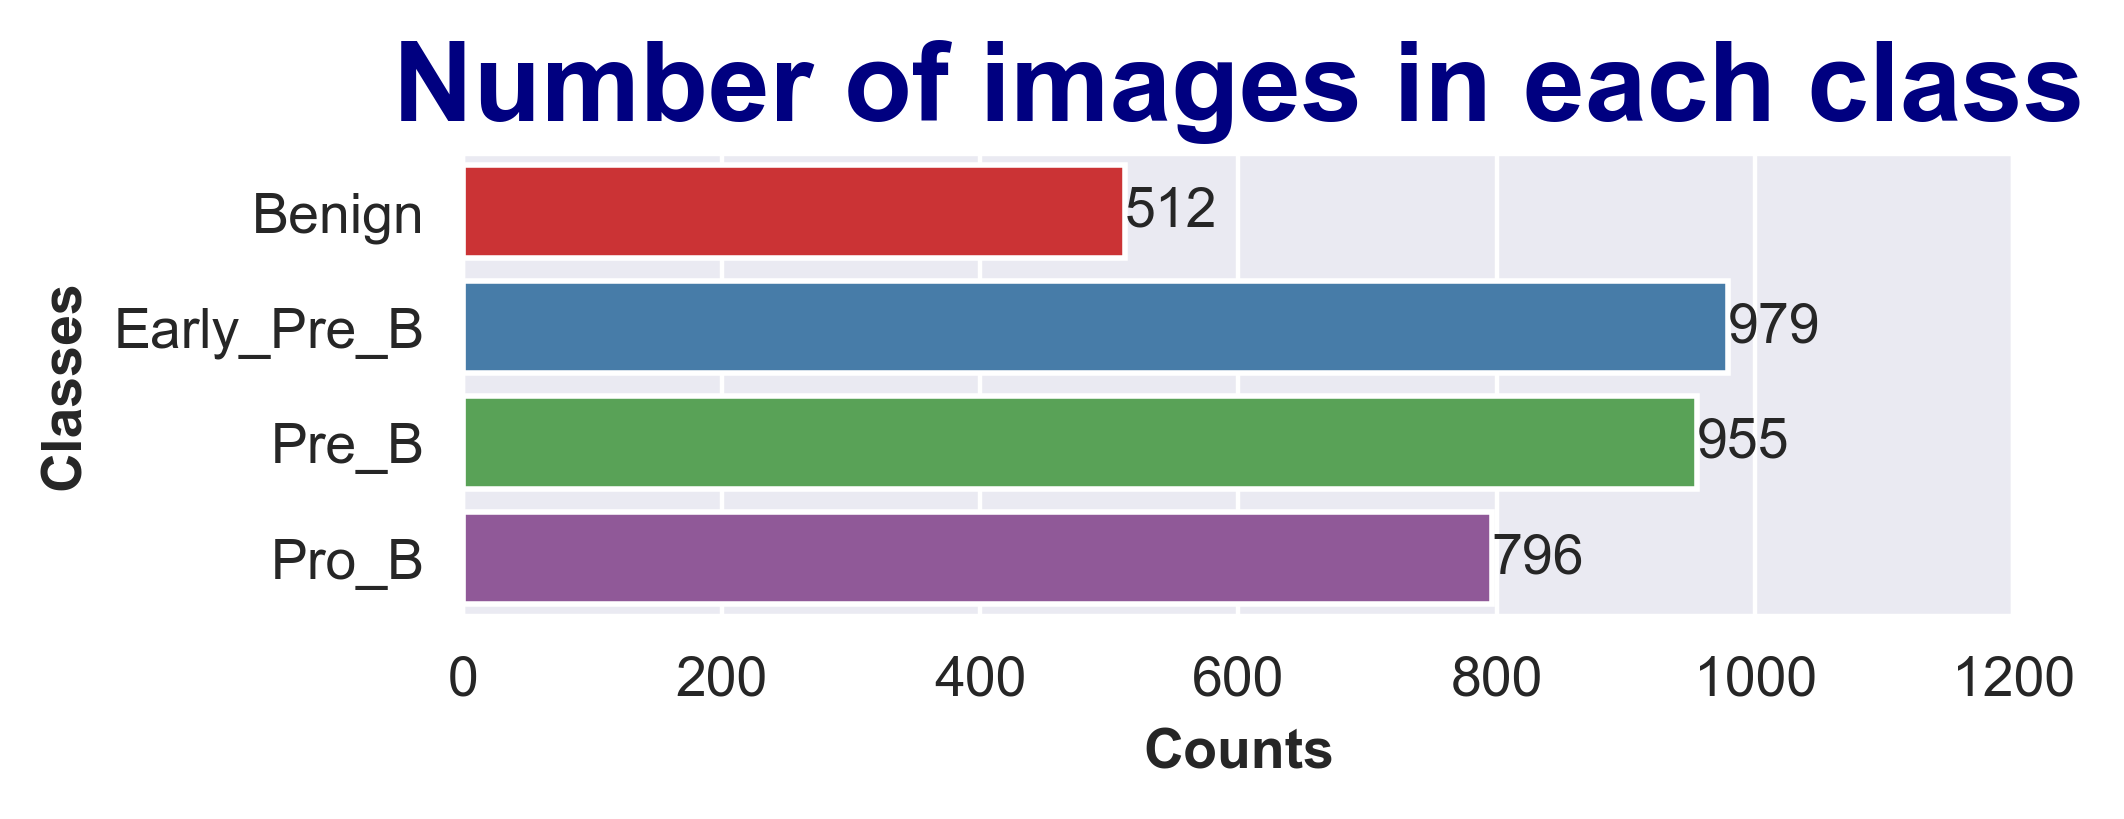

In [11]:
counts = []
for class_name in classes :
    class_path = os.path.join(Images, class_name)
    counts.append(len(os.listdir(class_path)))

plt.figure(figsize=(5, 1.5), dpi=400)
ax = sns.barplot(x=counts, y=classes, palette='Set1', hue=classes)
for i in range(len(classes)) :
    ax.bar_label(ax.containers[i])
plt.title('Number of images in each class', fontsize=20, fontweight='bold', c='navy')
ax.set_xlim(0, 1200)
ax.set_xlabel('Counts', fontweight='bold')
ax.set_ylabel('Classes', fontweight='bold')
plt.show()

## Plot images

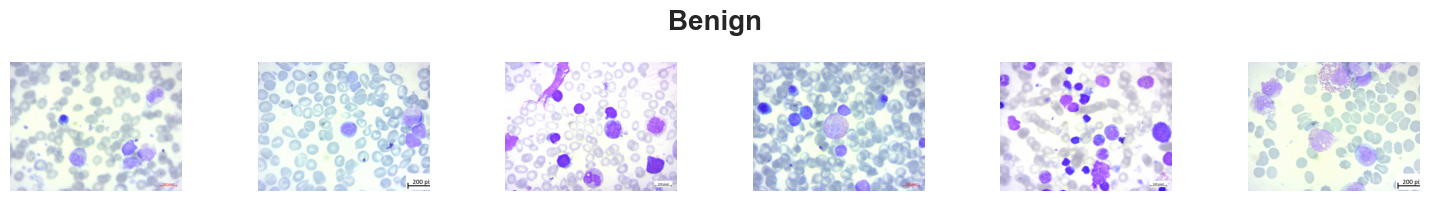

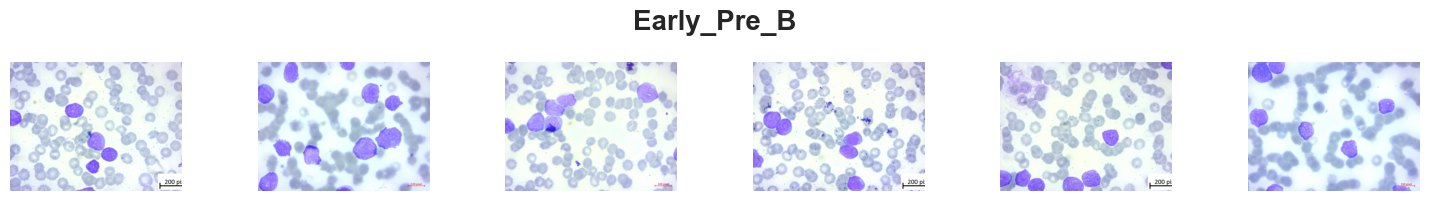

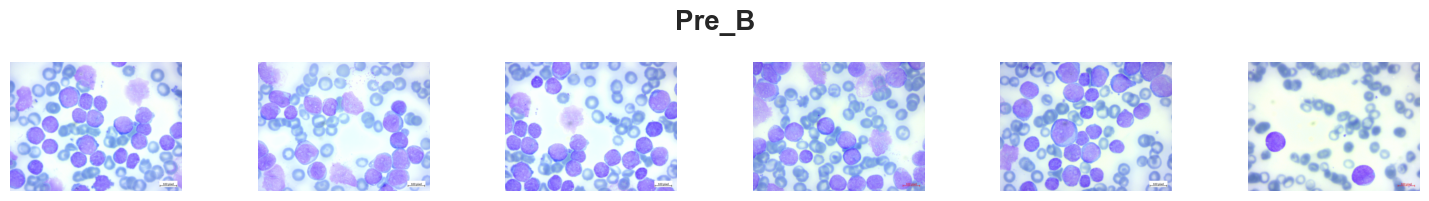

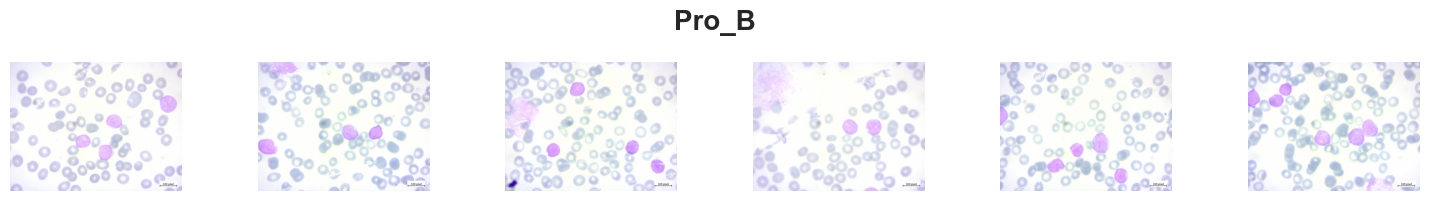

In [12]:
# A loop to iterate below codes for each class
for class_name in classes :
    # To create a plot with 1 row and 6 column
    fig, ax = plt.subplots(1, 6, figsize=(15, 2))
    # Define a variable for each class_name's path by joining base_directory and each class_name
    class_path = os.path.join(Images, class_name)
    # Files is a list of all image names in each folder (class)
    files = os.listdir(class_path)
    # Choose 6 random image from each class to show in plot
    random_images = random.choices(files, k=6)
    # A loop to iterate in each 6 random images
    for i in range(6) :
        # print class_name as suptitle for each class
        plt.suptitle(class_name, fontsize=20, fontweight='bold')
        # variable img is path of image, by joining class_path and image file name
        img = os.path.join(class_path ,random_images[i])
       # load image in img variable using keras.utils.load_img(image_path) 
        img = Image.open(img)
        # Plot image
        ax[i].imshow(img)
        # Turn axis off
        ax[i].axis('off')
    # Make plots to become nearer to each other
    plt.tight_layout()

## Split images to Train-Valid-test folders

In [13]:
# create folder for train and validation and test
train_valid = os.path.join(working_dir, 'train_valid')

# splitfolders.ratio(
#     input=Images, output=train_valid, seed=42, ratio=(0.7, 0.15, 0.15)
# )

print(colored(f' All images splited to TRAIN / VALIDATION / TEST folders. ', 'white', 'on_green', attrs=['bold']))

 All images splited to TRAIN / VALIDATION / TEST folders. 


## Data Augmentation

In [14]:
sample_image = os.path.join(Benign, 'Sap_013 (1).jpg')

### Blure

In [15]:
def Blure_Filter(img, filter_type ="blur", kernel=13):
    '''
    ### Filtering ###
    img: image
    filter_type: {blur: blur, gaussian: gaussian, median: median}
    '''
    if filter_type == "blur":
        return cv2.blur(img,(kernel,kernel))
    
    elif filter_type == "gaussian":
        return cv2.GaussianBlur(img, (kernel, kernel), 0)
    
    elif filter_type == "median":
        return cv2.medianBlur(img, kernel)

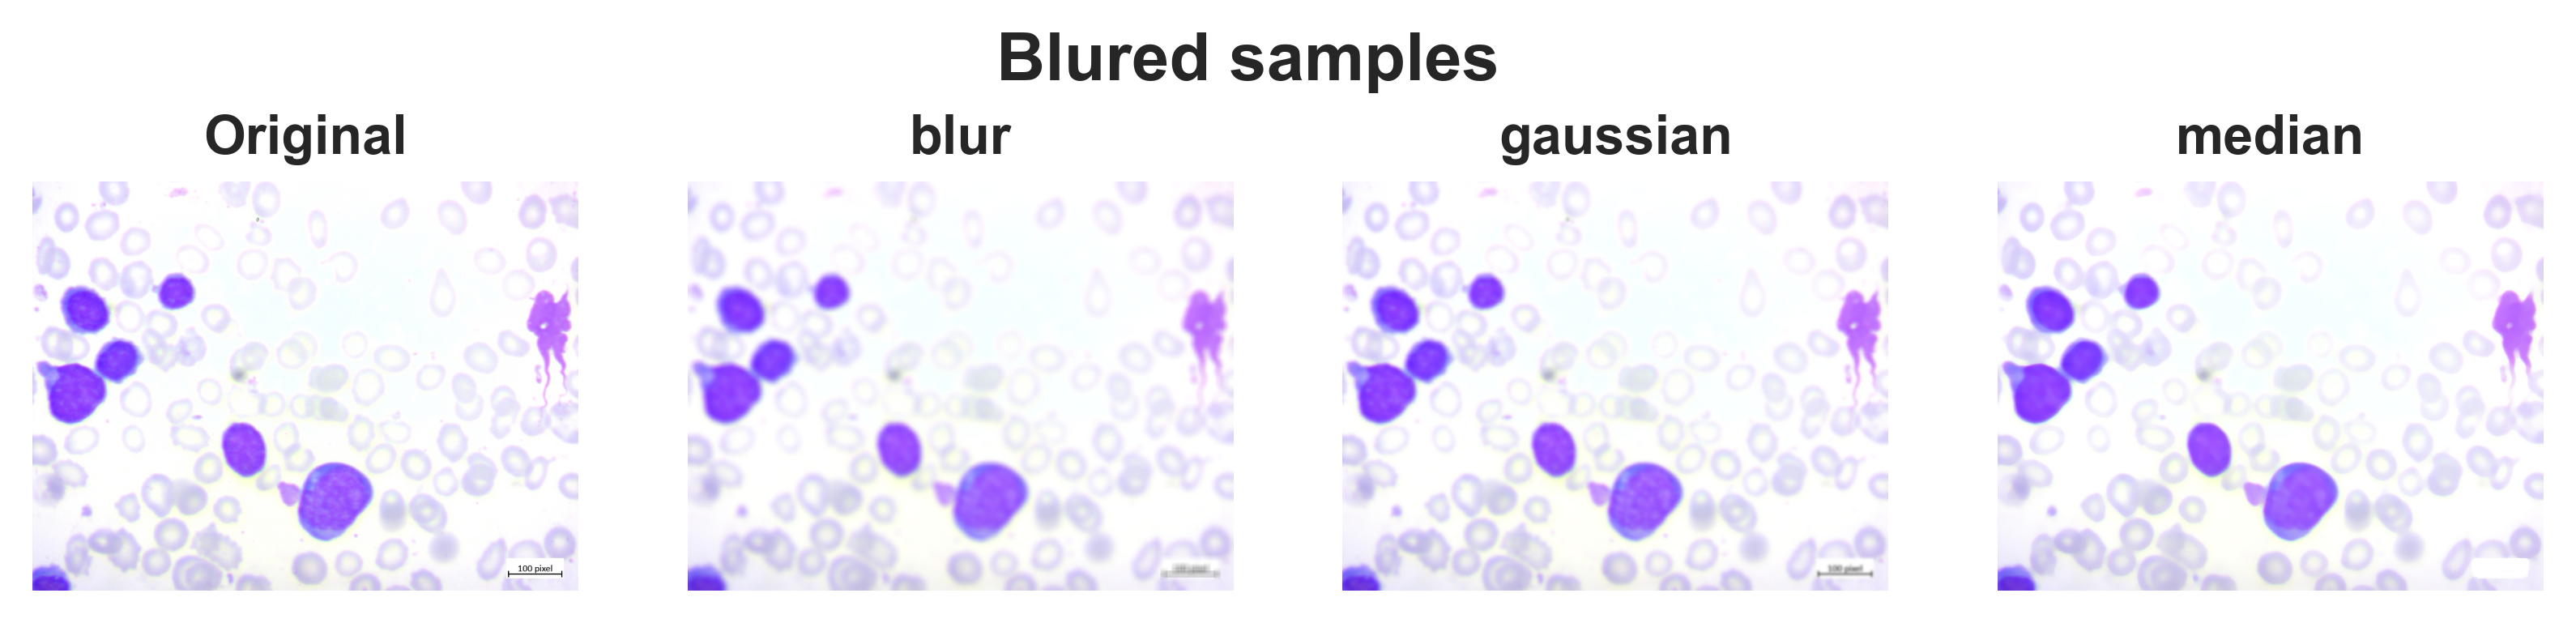

In [16]:
plt.figure(figsize=(10, 2.25), dpi=400)
plt.suptitle('Blured samples', fontweight='bold', fontsize=15)
plt.subplot(1, 4, 1)
img = cv2.imread(sample_image)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.title('Original', fontweight='bold')

filters = ['blur', 'gaussian', 'median']
for filter in filters :
    indx = filters.index(filter)
    plt.subplot(1, 4, indx+2)
    filtered_img = Blure_Filter(img, filter_type=filter, kernel=13)
    plt.imshow(filtered_img)
    plt.axis('off')
    plt.title(filter, fontweight='bold')

### Noise

In [17]:
def Add_Noise(img, noise_type="gauss"):
    '''
    ### Adding Noise ###
    img: image
    cj_type: {gauss: gaussian, sp: salt & pepper}
    '''
    if noise_type == "gauss": 
        mean=0
        st=0.5
        gauss = np.random.normal(mean,st,img.shape)
        gauss = gauss.astype('uint8')
        image = cv2.add(img,gauss)
        return image
    
    elif noise_type == "sp": 
        prob = 0.01
        black = np.array([0, 0, 0], dtype='uint8')
        white = np.array([255, 255, 255], dtype='uint8')

        probs = np.random.random(img.shape[:2])
        img[probs < (prob / 2)] = black
        img[probs > 1 - (prob / 2)] = white
        return img

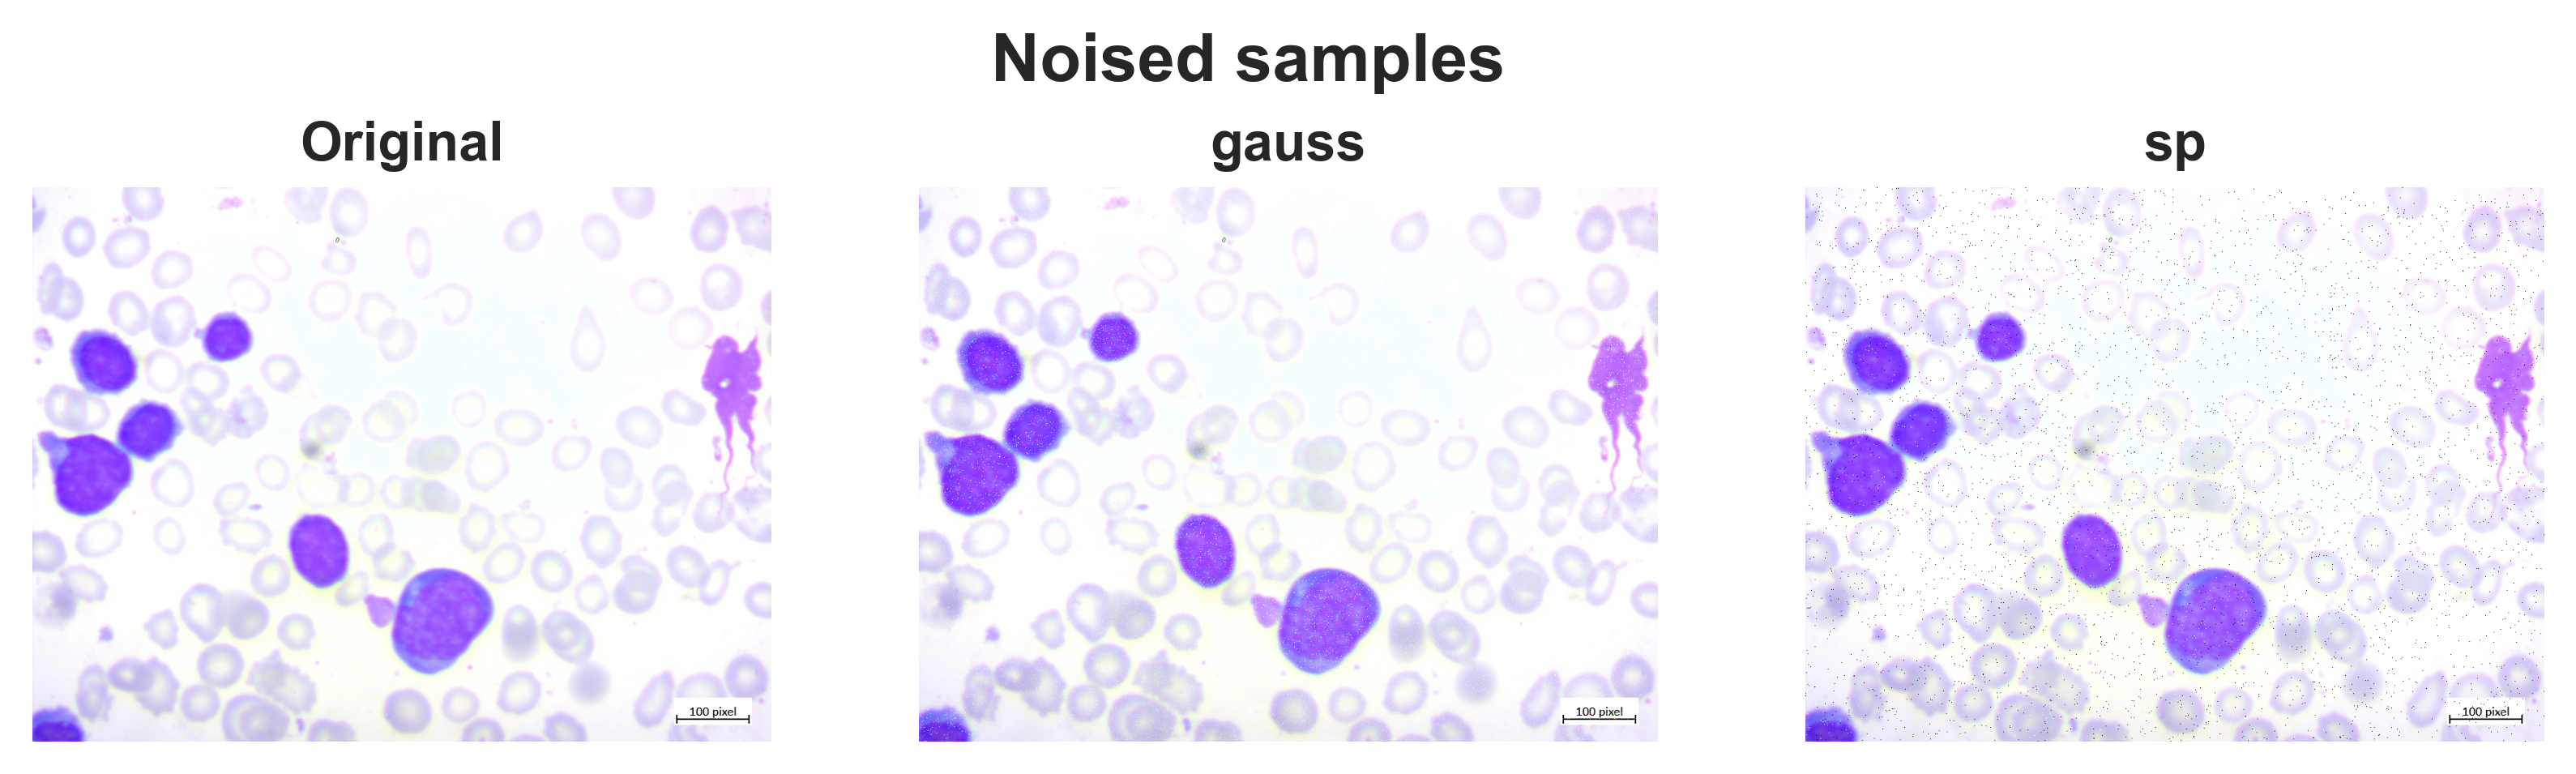

In [18]:
plt.figure(figsize=(10, 2.75), dpi=400)
plt.suptitle('Noised samples', fontweight='bold', fontsize=15)
plt.subplot(1, 3, 1)
img = cv2.imread(sample_image)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.title('Original', fontweight='bold')

noises = ['gauss', 'sp']
for noise in noises :
    indx = noises.index(noise)
    plt.subplot(1, 3, indx+2)
    noised_img = Add_Noise(img, noise_type=noise)
    plt.imshow(noised_img)
    plt.axis('off')
    plt.title(noise, fontweight='bold')

### Flip

In [19]:
def Flip(img, flip_code) :
    flipped_img = cv2.flip(img, flip_code)
    return flipped_img

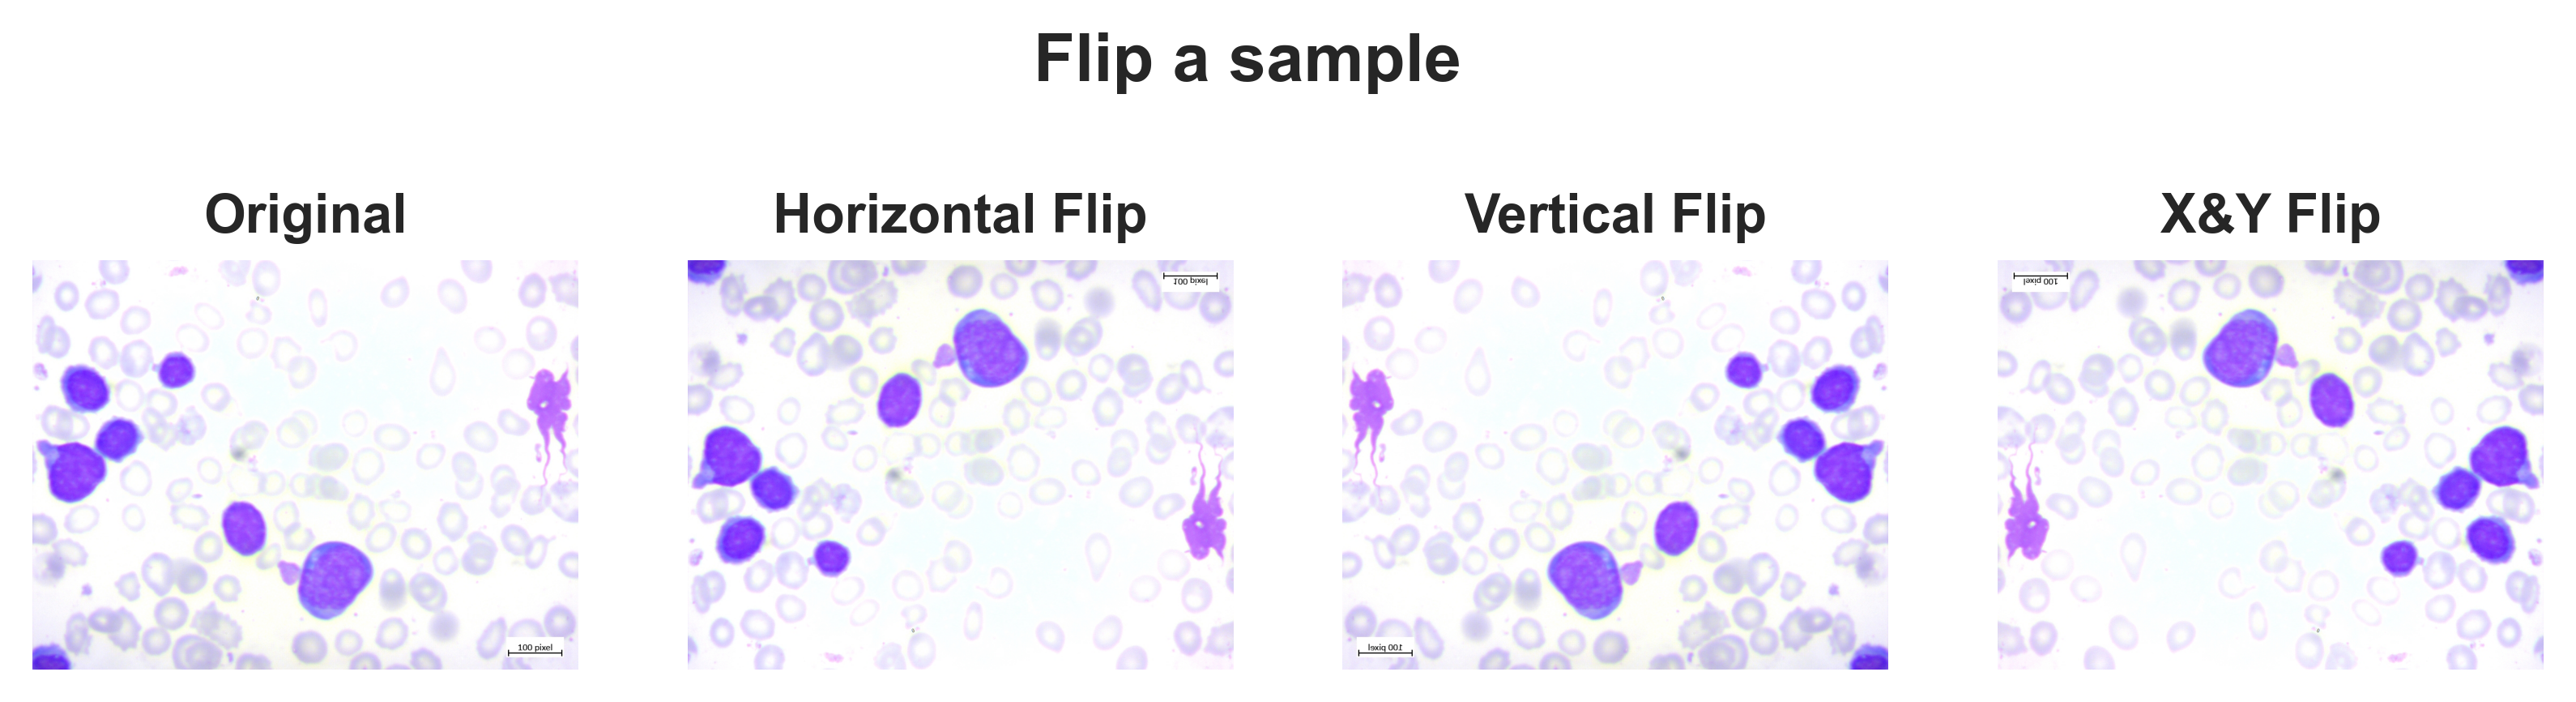

In [20]:
plt.figure(figsize=(10, 2.75), dpi=400)
plt.suptitle('Flip a sample', fontweight='bold', fontsize=15)

plt.subplot(1, 4, 1)
img = cv2.imread(sample_image)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.title('Original', fontweight='bold')

plt.subplot(1, 4, 2)
fliped = Flip(img, flip_code=0)
plt.imshow(fliped)
plt.axis('off')
plt.title('Horizontal Flip', fontweight='bold')

plt.subplot(1, 4, 3)
fliped = Flip(img, flip_code=1)
plt.imshow(fliped)
plt.axis('off')
plt.title('Vertical Flip', fontweight='bold')

plt.subplot(1, 4, 4)
fliped = Flip(img, flip_code=-1)
plt.imshow(fliped)
plt.axis('off')
plt.title('X&Y Flip', fontweight='bold')
plt.show()

In [21]:
def Apply_Augmentations(img) :

    returned_augs = dict()

    AUGS = ['Blure', 'Noise', 'Flip']

    # How many of Augs choosen ?
    random_num = random.randint(1, 3)
    random_choice = random.choices(AUGS, k=random_num)
    # To avoid repeatations :
    random_choice = list(set(random_choice))

    for choice in random_choice :
        if choice == 'Blure' :
            filters = ['blur', 'gaussian', 'median']
            kernels = [5, 7, 9, 11]
            random_filter = random.choices(filters, k=1)[0]
            random_kernel = random.choices(kernels, k=1)[0]
            blured_img =  Blure_Filter(img, filter_type=random_filter, kernel=random_kernel)
            new_name = '_blured'
            returned_augs[new_name] = blured_img


        elif choice == 'Noise' :
            noises = ['gauss', 'sp']
            random_noise = random.choices(noises, k=1)[0]
            noised_img = Add_Noise(img, noise_type=random_noise)
            new_name = '_noised'
            returned_augs[new_name] = noised_img


        elif choice == 'Flip' :
            flip_codes = [-1, 0, 1]
            random_code = random.choices(flip_codes, k=1)[0]
            flipped_img = Flip(img, flip_code=random_code)
            new_name = '_fliped'
            returned_augs[new_name] = flipped_img
            
    return returned_augs

In [22]:
train_dir = os.path.join(train_valid, 'train')
num_samples_befor_aug = 0

for folder in os.listdir(train_dir) :
    folder_path = os.path.join(train_dir, folder)
    num_samples_befor_aug += len(os.listdir(folder_path))

print(colored(f'Number of samples in TRAIN folder befor Augmentation : {num_samples_befor_aug} ', 'black', 'on_white', attrs=['bold']))

Number of samples in TRAIN folder befor Augmentation : 2268 


In [23]:
# for folder in os.listdir(train_dir) :
#     folder_path = os.path.join(train_dir, folder)
#     for img_name in tqdm(os.listdir(folder_path)) :
#         img_path = os.path.join(folder_path, img_name)
#         img = cv2.imread(img_path)
#         returned = Apply_Augmentations(img)

#         for exported_name, exported_image in returned.items() :
#             # 1_left.jpg ---TO---> 1_lef_blured.jpg
#             new_name = img_name.split('.')[0] + exported_name + '.' + img_name.split('.')[-1]
#             new_path = os.path.join(folder_path, new_name)
        
#             # Save new image
#             cv2.imwrite(new_path, exported_image)


print(colored(f' Augmentation Completed. ', 'white', 'on_green', attrs=['bold']))

 Augmentation Completed. 


In [24]:
num_samples_after_aug = 0

for folder in os.listdir(train_dir) :
    folder_path = os.path.join(train_dir, folder)
    num_samples_after_aug += len(os.listdir(folder_path))

print(colored(f'Number of samples  in TRAIN folder after Augmentation : {num_samples_after_aug} ', 'black', 'on_white', attrs=['bold']))

Number of samples  in TRAIN folder after Augmentation : 2268 


In [25]:
print(colored(f' {num_samples_after_aug-num_samples_befor_aug} images added to train directory. ', 'white', 'on_blue', attrs=['bold']))

 0 images added to train directory. 


# DataSets and DataLoaders

In [26]:
transform = transforms.Compose(
    [
        transforms.Resize(img_size),
        transforms.ToTensor()
    ]
)

In [27]:
############################# TRAIN #############################
# Dataset
train_ds = ImageFolder(root=os.path.join(train_valid, 'train'), transform=transform)

# DataLoader
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

print(colored(f'TRAIN Folder :\n', 'green', 'on_white', attrs=['bold']))
print(train_ds)

############################# VALIDATION #############################
# Dataset
valid_ds = ImageFolder(root=os.path.join(train_valid, 'val'), transform=transform)

# DataLoader
valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)

print(colored(f'VALID Folder :\n', 'green', 'on_white', attrs=['bold']))
print(valid_ds)

############################# TEST #############################
# Dataset
test_ds = ImageFolder(root=os.path.join(train_valid, 'test'), transform=transform)

# DataLoader
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

print(colored(f'TEST Folder :\n', 'green', 'on_white', attrs=['bold']))
print(test_ds)

TRAIN Folder :

Dataset ImageFolder
    Number of datapoints: 2268
    Root location: C:\envs\Working\Blood_Cell_Cancer\train_valid\train
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
VALID Folder :

Dataset ImageFolder
    Number of datapoints: 484
    Root location: C:\envs\Working\Blood_Cell_Cancer\train_valid\val
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
TEST Folder :

Dataset ImageFolder
    Number of datapoints: 490
    Root location: C:\envs\Working\Blood_Cell_Cancer\train_valid\test
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


## DataShape

In [28]:
# print shape of dataset for each set
for key, value in {'Train': train_loader, "Validation": valid_loader, 'Test': test_loader}.items():
    for X, y in value:
        print(colored(f'{key}:', 'white','on_green', attrs=['bold']))
        print(f"Shape of images [Batch_size, Channels, Height, Width]: {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}\n")
        print('-'*45)
        break

Train:
Shape of images [Batch_size, Channels, Height, Width]: torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64

---------------------------------------------
Validation:
Shape of images [Batch_size, Channels, Height, Width]: torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64

---------------------------------------------
Test:
Shape of images [Batch_size, Channels, Height, Width]: torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64

---------------------------------------------


## FreeUp some space in RAM and GPU

In [29]:
del [ax, base_dir, Benign, class_name, class_path, counts, Early_Pre_B, fig, files, filter, filtered_img, filters, fliped, folder,  folder_path]
del [ i, Images, img, indx, key, noise, noised_img, noises, num_classes, num_samples_after_aug, num_samples_befor_aug, Pre_B, Pro_B, random_images]
del [sample_image, train_dir, value, working_dir, X, y]

gc.collect()

40574

In [30]:
torch.cuda.empty_cache()

# Model

## PreTrained

In [31]:
model = googlenet(weights=GoogLeNet_Weights)
model

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [32]:
model.fc = nn.Sequential(
    nn.Linear(in_features=1024, out_features=512),
    nn.ReLU(),
    nn.Dropout(0.2),
     nn.Linear(in_features=512, out_features=128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(in_features=128, out_features=64),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(in_features=64, out_features=4)
)

In [33]:
model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

## Train the Model

In [34]:
def DeltaTime(dt) :
    '''A Function to apply strftime manualy on delta.datetime class'''
    h = dt.seconds // 3600
    dh = dt.seconds % 3600

    m = dh // 60
    s = dh % 60

    if h<10 : h='0'+str(h)
    else : h = str(h)

    if m<10 : m='0'+str(m)
    else : m = str(m)

    if s<10 : s='0'+str(s)
    else : s = str(s)

    return( h + ':' + m + ':' + s)

In [35]:
def Beauty_epoch(epoch) :
    ''' Return epochs in 2 digits - like (01 or 08) '''
    if epoch<10 :
        return '0' + str(epoch)
    else :
        return str(epoch)

In [36]:
def Reduce_lr(list_of_valid_losses, epoch, lr) :
    ''' Reduce learning rate if valid loss do not decrease for 3 epochs '''
    if len(list_of_valid_losses) > 4 :
        current_loss = list_of_valid_losses[-1]
        befor_1 = list_of_valid_losses[-2]
        befor_2 = list_of_valid_losses[-3]
        if ((current_loss > befor_1) and (befor_1 > befor_2)) or (epoch % 10 == 0) :
            lr /= 2
    return lr

In [37]:
num_epochs = 30

In [38]:
# Create Loss_function and Optimizer
Learning_Rate = 0.02

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=Learning_Rate)

# Some variables to store loss and accuracy to plot them
train_losses = np.zeros(num_epochs)
train_accs = np.zeros(num_epochs)
valid_losses = np.zeros(num_epochs)
valid_accs = np.zeros(num_epochs)

print(colored('Training Starts ... ', 'blue', 'on_white', attrs=['bold']))
for epoch in range(num_epochs) :
    # Set the mode to TRAIN
    model.train()

    # Current time to calculate duration of epoch
    t0 = datetime.now()

    # Some variables to store data
    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []
    n_correct = 0
    n_total = 0

            ###############
            #### Train ####
            ###############

    # Read Images and Labels from TrainLoader
    for images, labels in train_loader :
        # Move Data to GPU
        images = images.to(device)
        labels = labels.to(device)

        # Reshape labels to [Batch-Size, 1]
        # labels = torch.reshape(labels, (-1, 1))

        # Zero Grad Optimizer
        optimizer.zero_grad()

        # Forward Pass
        y_pred = model(images)
        loss = criterion(y_pred, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Train Loss
        train_loss.append(loss.item())

        # Train Accuracy
        _, prediction = torch.max(y_pred, 1)
        n_correct += (prediction==labels).sum().item()
        n_total += labels.shape[0]

    train_losses[epoch] = np.mean(train_loss)
    train_accs[epoch] = n_correct / n_total

            ####################
            #### Validation ####
            ####################

    n_correct = 0
    n_total = 0

    # Read Images and Labels from ValidLoader
    for images, labels in valid_loader :
        # Move Data to GPU
        images = images.to(device)
        labels = labels.to(device)

        # Reshape labels to [Batch-Size, 1]
        # labels = torch.reshape(labels, (-1, 1))

        # Forward pass
        y_pred = model(images)
        loss = criterion(y_pred, labels)

        # Validation Loss
        valid_loss.append(loss.item())

        # val Accuracy
        _, prediction = torch.max(y_pred, 1)
        n_correct += (prediction==labels).sum().item()
        n_total += labels.shape[0]
    
    valid_losses[epoch] = np.mean(valid_loss)
    valid_accs[epoch] = n_correct / n_total


    ############################# LR ################################
    Learning_Rate = Reduce_lr(valid_losses, epoch, lr=Learning_Rate)



    ############################# Duration ################################
    dt = datetime.now() - t0

    ####################### BEAUTIFULL OUTPUT #######################
    EPOCH =  colored(f' Epoch [{Beauty_epoch(epoch+1)}/{num_epochs}] ', 'black', 'on_white', attrs=['bold'])
    TRAIN_LOSS = colored(f' Train Loss:{train_losses[epoch]:.4f} ', 'white', 'on_green', attrs=['bold'])
    TRAIN_ACC = colored(f' Train Acc:{train_accs[epoch]:.4f} ', 'white', 'on_blue', attrs=['bold'])
    VAL_LOSS = colored(f' Val Loss:{valid_losses[epoch]:.4f} ', 'white', 'on_green', attrs=['bold'])
    VAL_ACC = colored(f' Val Acc:{valid_accs[epoch]:.4f} ', 'white', 'on_blue', attrs=['bold'])
    DURATION = colored(f' Duration : {DeltaTime(dt)} ', 'white', 'on_dark_grey', attrs=['bold'])
    LR = colored(f' lr = {Learning_Rate} ', 'black',  'on_cyan', attrs=['bold'])


    # Print the result of  each epochs
    print(f'{EPOCH} -> {TRAIN_LOSS}{TRAIN_ACC} {VAL_LOSS}{VAL_ACC} {DURATION} {LR}')


print(colored('Training Finished ...', 'blue', 'on_white', attrs=['bold']))


Training Starts ... 
 Epoch [01/30]  ->  Train Loss:1.4594  Train Acc:0.3417   Val Loss:1.2254  Val Acc:0.3719   Duration : 00:02:12  lr = 0.01 


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(train_accs, label='Train Accuracy')
ax[0].plot(valid_accs, label='TestValidation Accuracy')
ax[0].set_title('Accuracy')
ax[0].legend()

ax[1].plot(train_losses, label='Train Loss')
ax[1].plot(valid_losses, label='Validation Loss')
ax[1].set_title('Loss')
ax[1].legend()

plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report # To Evaluate the result

In [ ]:
with torch.no_grad() :
    model.eval()
    t0 = datetime.now()
    test_loss = []
    val_loss = []
    n_correct = 0
    n_total = 0

    for images, labels in test_loader :
        # Move input data to GPU
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        y_pred = model(images)
        loss = criterion(y_pred, labels)

        # Train Loss
        test_loss.append(loss.item())

        # Train Accuracy
        _, prediction = torch.max(y_pred, 1)
        n_correct += (prediction==labels).sum().item()
        n_total += labels.shape[0]

    test_loss = np.mean(train_loss)
    train_acc = n_correct / n_total
    dt = datetime.now() - t0
    print(colored(f'Loss:{test_loss:.4f}\nAccuracy:{train_acc:.4f}\nDuration:{dt}', 'green', attrs=['bold']))

In [ ]:
classes

In [ ]:
# Move model to CPU
cpu_model = model.cpu()

# Get 1 batch of test_loader
for imgs, labels in test_loader :
    break

# Plot 1 batch of test_loader images with True and Predicted label
plt.subplots(4, 8, figsize=(16, 12))
plt.suptitle('Rice images in 1 Batch', fontsize=25, fontweight='bold')
for i in range(32) :
    ax = plt.subplot(4, 8, i+1)
    img = torch.permute(imgs[i], (1, 2, 0))
    plt.imshow(img)
    label = labels_map[int(labels[i])]
    img = img[i].unsqueeze(0)
    img = imgs[i].unsqueeze(0)
    out = cpu_model(img)
    predict = labels_map[int(out.argmax())]
    plt.title(f'True :{label}\nPredict :{predict}')
    plt.axis('off')

plt.show()

In [ ]:
# Get out 2 list include y_true and y_pred for use in confusion_matrix
model = model.to(device)

y_true = []
y_pred = []
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.numpy()
    outputs = model(images)
    _, pred = torch.max(outputs.data, 1)
    pred = pred.detach().cpu().numpy()
    
    y_true = np.append(y_true, labels)
    y_pred = np.append(y_pred, pred)

In [ ]:
classes = labels_map.values()

print(classification_report(y_true, y_pred))

def plot_confusion_matrix(y_test, y_prediction):
    '''Plotting Confusion Matrix'''
    cm = confusion_matrix(y_true, y_pred)
    ax = plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cm, annot=True, fmt='', cmap="Blues")
    ax.set_xlabel('Prediced labels', fontsize=18)
    ax.set_ylabel('True labels', fontsize=18)
    ax.set_title('Confusion Matrix', fontsize=25)
    ax.xaxis.set_ticklabels(classes)
    ax.yaxis.set_ticklabels(classes) 
    plt.show()


plot_confusion_matrix(y_true, y_pred)